<a href="https://colab.research.google.com/github/Ruturaj123/MNIST-GAN/blob/master/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%load_ext autoreload
%matplotlib inline

## Import the dependencies

In [0]:
%autoreload 2

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from utils import Logger
from IPython import display

## Load Data

In [0]:
def get_mnist():
    compose = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=False)

data = get_mnist()
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
batches = len(data_loader)

## Discriminator

In [0]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        n_features = 784
        n_out = 1
        
        self.h_0 = nn.Sequential(
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.h_1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.h_2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.out = nn.Sequential(
            nn.Linear(256, n_out),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.h_0(x)
        x = self.h_1(x)
        x = self.h_2(x)
        x = self.out(x)
        return x

## Helper functions

In [0]:
def image2vec(images):
    return images.view(images.size(0), 784)

def vec2image(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

## Generator

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        n_features = 100
        n_out = 784
        
        self.h_0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        
        self.h_1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        
        self.h_2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.h_0(x)
        x = self.h_1(x)        
        x = self.h_2(x)        
        x = self.out(x)
        
        return x

In [0]:
discriminator = Discriminator()
generator = Generator()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

## Noise

In [0]:
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n

## Optimizer and Loss

In [0]:
d_optim = optim.Adam(discriminator.parameters(), lr = 0.0002)
g_optim = optim.Adam(generator.parameters(), lr = 0.0002)

loss = nn.BCELoss()

In [0]:
def ones_target(size):
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def zeros_target(size):
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

## Train Discriminator

In [0]:
def train_D(optimizer, real, fake):
    n = real.size(0)
    optimizer.zero_grad()
    
    #Train on real data
    prediction_r = discriminator(real)
    err_r = loss(prediction_r, ones_target(n))
    err_r.backward()
    
    #Train on fake data
    prediction_f = discriminator(fake)
    err_f = loss(prediction_f, zeros_target(n))
    err_f.backward()
    
    #Update the weights
    optimizer.step()
    
    error = err_r + err_f
    
    return error, prediction_r, prediction_f

## Train Generator

In [0]:
def train_G(optimizer, fake):
    optimizer.zero_grad()
    
    #Generate fake data
    prediction = discriminator(fake)
    
    #Calculate loss and backpropagate
    error = loss(prediction, ones_target(prediction.size(0)))
    error.backward()
    #Update the weights
    optimizer.step()
    
    return error

### Generate Samples for Testing

In [0]:
n_samples = 16
test_noise = noise(n_samples)

### Start training

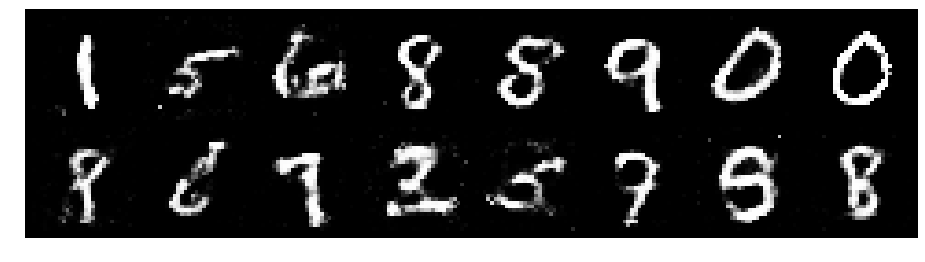

In [0]:
logger = Logger(model_name='MNIST GAN', data_name='MNIST')

for epoch in range(n_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        #Training Discriminator
        real_data = Variable(image2vec(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_D(d_optim,real_data, fake_data)

        #Training Generator
        fake_data = generator(noise(real_batch.size(0)))
        g_error = train_G(g_optim, fake_data)
        
        logger.log(d_error, g_error, epoch, n_batch, batches)

        #Log Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            
            test_images = vec2image(generator(test_noise)).data.cpu()
            logger.log_images(test_images, n_samples, epoch, n_batch, batches)